In [2]:
#Main libraries
import os
import glob
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pandas as pd
from collections import deque

#sklearn libraries
from skimage.feature import hog
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

#video settings 
from moviepy.editor import VideoFileClip
from IPython.display import HTML

plt.rcParams["figure.figsize"] = [25,15]

In [3]:
#Importing test images
image_list = [] #for test images
car_list = [] #sample cars
random_list = [] #sample random stuff 

for filename in glob.glob('./test_images/*.jpg'): #assuming gif
    image_list.append(filename)

for filename in glob.glob('./sample_car/*.png'): 
    car_list.append(filename)
    
for filename in glob.glob('./sample_stuff/*.png'): 
    random_list.append(filename)

## HOG Features Implementation

In [3]:

# Generate a random index to look at a car image
ind = np.random.randint(0, len(car_list))
# Read in the image
image = car_list[ind]
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

TypeError: src is not a numpy array, neither a scalar

## Feature Extraction

In [186]:
def extract_features_flipped(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs: 
        image = cv2.imread(file)
        image = cv2.flip(image,1)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        #Get HOG features
        hog_features = get_hog_features(feature_image, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=True, channel='ALL')
        hog_features = np.ravel(hog_features)
        # Append the new feature vector to the features list        
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        #features.append(np.concatenate((hist_features, hog_features)))
        #features.append(hog_features)
    # Return list of feature vectors
    return features


In [14]:
#Udacity lesson code
# Modified extract function code since first part of code has already read inmage 
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs: 
        image = cv2.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        #Get HOG features
        hog_features = get_hog_features(feature_image, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=True, channel='ALL')
        hog_features = np.ravel(hog_features)
        # Append the new feature vector to the features list        
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        #features.append(np.concatenate((hist_features, hog_features)))
        #features.append(hog_features)
    # Return list of feature vectors
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

#Udacity lesson code 
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=True, 
                     feature_vec=True, channel=0):
                         
    # TODO: Complete the function body and returns
#     pix_per_cell = 8
#     cell_per_block = 2
#     orient = 9

    if(channel != 'ALL'): 
        hog_features = hog(img[:,:,channel], orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  visualise=False, feature_vector=feature_vec,
                                  block_norm="L2-Hys")
    else: 
        hog_features = []
        for i in range(img.shape[2]): 
                hog_features_loc = hog(img[:,:,i], orientations=orient,
                              pixels_per_cell=(pix_per_cell, pix_per_cell), 
                              cells_per_block=(cell_per_block, cell_per_block), 
                              visualise=False, feature_vector=feature_vec,
                              block_norm="L2-Hys")
                hog_features.append(hog_features_loc)
        hog_features = np.ravel(hog_features)
    
    return hog_features


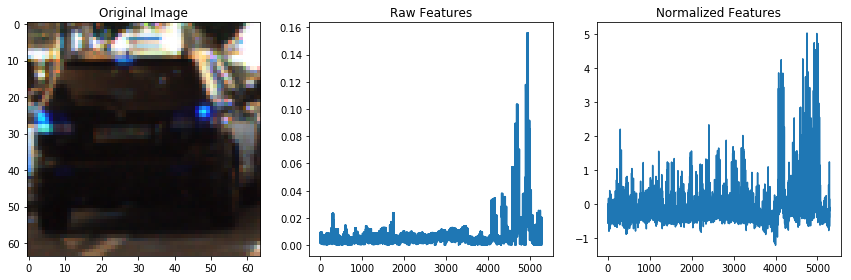

In [5]:
car_features = extract_features(car_list, cspace='HSV', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(random_list, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_flipped_lr = extract_features_flipped(random_list, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features, notcar_flipped_lr)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(car_list))
    img_orig = cv2.imread(car_list[car_ind])
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img_orig, cmap = 'RdBu')
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(1,3,3)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')


## Import Data
Import training data for the classifier and split into training and validation set 

In [6]:
#Import training data from folders 
vehicle_list = [] 
nonvehicle_list = []
for dir in os.listdir('./vehicles/'):
    path = './vehicles/' + dir + '/'
    for filename in glob.glob(path+'*.png'): #assuming gif
        vehicle_list.append(filename)
   
for dir in os.listdir('./non-vehicles/'):
    path = './non-vehicles/' + dir + '/'
    for filename in glob.glob(path+'*.png'):
        nonvehicle_list.append(filename)


In [187]:
#Split into training and validation set 

car_features = extract_features(vehicle_list, cspace='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
noncar_features = extract_features(nonvehicle_list, cspace='YCrCb')
noncarflipped_features = extract_features_flipped(nonvehicle_list, cspace='YCrCb')
X = np.vstack((car_features, noncar_features, noncarflipped_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)




In [191]:
#Prepare y dataset
y_vehicles = np.ones(len(vehicle_list))
y_nonvehicles = np.zeros(len(nonvehicle_list))
Y = np.concatenate((y_vehicles, y_nonvehicles, y_nonvehicles))

#split data
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, Y, test_size=0.1, random_state=np.random.randint(0,100))

## Build Classifier


In [192]:
#clf = LinearSVC(C = 0.01)
clf = LinearSVC()
clf.fit(X_train, Y_train)

y_predict = clf.predict(X_test)
accuracy = clf.score(X_test, Y_test)
print(accuracy)



0.984661429106


## Sliding Windows

In [193]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    rectangles = [] 
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    #Colorspace conversion
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YCrCb)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

    # Compute individual channel HOG feat)ures for the entire image
    hog1 = get_hog_features(ctrans_tosearch, orient, pix_per_cell, cell_per_block, feature_vec=False, channel=0)
    hog2 = get_hog_features(ctrans_tosearch, orient, pix_per_cell, cell_per_block, feature_vec=False, channel=1)
    hog3 = get_hog_features(ctrans_tosearch, orient, pix_per_cell, cell_per_block, feature_vec=False, channel=2)
    
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((hist_features, hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(hog_features.reshape(1, -1))
            #test_features = np.concatenate((spatial_size, hist_features, hog_features))
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
                
    return rectangles
    


In [105]:
#Lesson Code 
pic = cv2.imread('./test_images/test2.jpg')
ystart = 400
ystop = 635
scale = 1.2

rectangles = find_cars(pic, ystart, ystop, scale, clf, X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=(32,32), hist_bins=32)
draw_img = np.copy(pic)
#for rectangle in rectangles: 
#    cv2.rectangle(draw_img, rectangle[0], rectangle[1], (255,0,0),6)

#plt.imshow(cv2.cvtColor(draw_img,cv2.COLOR_BGR2RGB))

## Filter overlapping squares and also false positives

In [162]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def remove_heat(heatmap, bbox_list): 
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] -= 1
        
        heatmap[heatmap < 0] = 0

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rectangles = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        rectangles.append(bbox)
        
    # Return the image
    return img

def get_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rectangles = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        rectangles.append(bbox)
        
    # Return the image
    return rectangles


In [61]:
# Add heat to each box in box list
heat = np.zeros_like(pic[:,:,0]).astype(np.float64)
heat = add_heat(heat,rectangles)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(pic), labels)


In [ ]:
fig = plt.figure()
plt.subplot(121)
plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Pipeline

In [203]:
stored_heat = deque(maxlen=7)

def pipeline(img):
    ystart = 400
    ystop = 656
    scale1 = 1.2
    scale2 = 1.67
    scale3 = 1.9
    

    draw_img = np.copy(img)
    rectangles1 = find_cars(img, ystart, ystop, scale3, clf, X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=(32,32), hist_bins=32)
    rectangles2 = find_cars(img, ystart, ystop, scale2, clf, X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=(32,32), hist_bins=32)
    rectangles =  rectangles2
#    for i in range(len(rectangles)):
#        box = rectangles[i]
#        cv2.rectangle(draw_img, box[0], box[1], (0, 0, 255), 6)
    heat = np.zeros_like(img[:,:,0]).astype(np.float64)
    heat = add_heat(heat,rectangles2)
#    heat = add_heat(heat, rectangles1)
    heat = apply_threshold(heat, 1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    boxes = get_labeled_bboxes(img, labels)
#    draw_img = draw_labeled_bboxes(img, labels)
    stored_heat.append(boxes)
        
    heat_box = np.zeros_like(img[:,:,0]).astype(np.float64)
    for i in range(len(stored_heat)): 
        currBox = stored_heat[i]
        heat_box = add_heat(heat_box, currBox)
       
    heat_box = apply_threshold(heat_box, 2)
    heatmap_box = np.clip(heat_box, 0, 255)
    labels_box = label(heatmap_box)
    draw_img = draw_labeled_bboxes(img, labels_box)     
           
    
    return draw_img

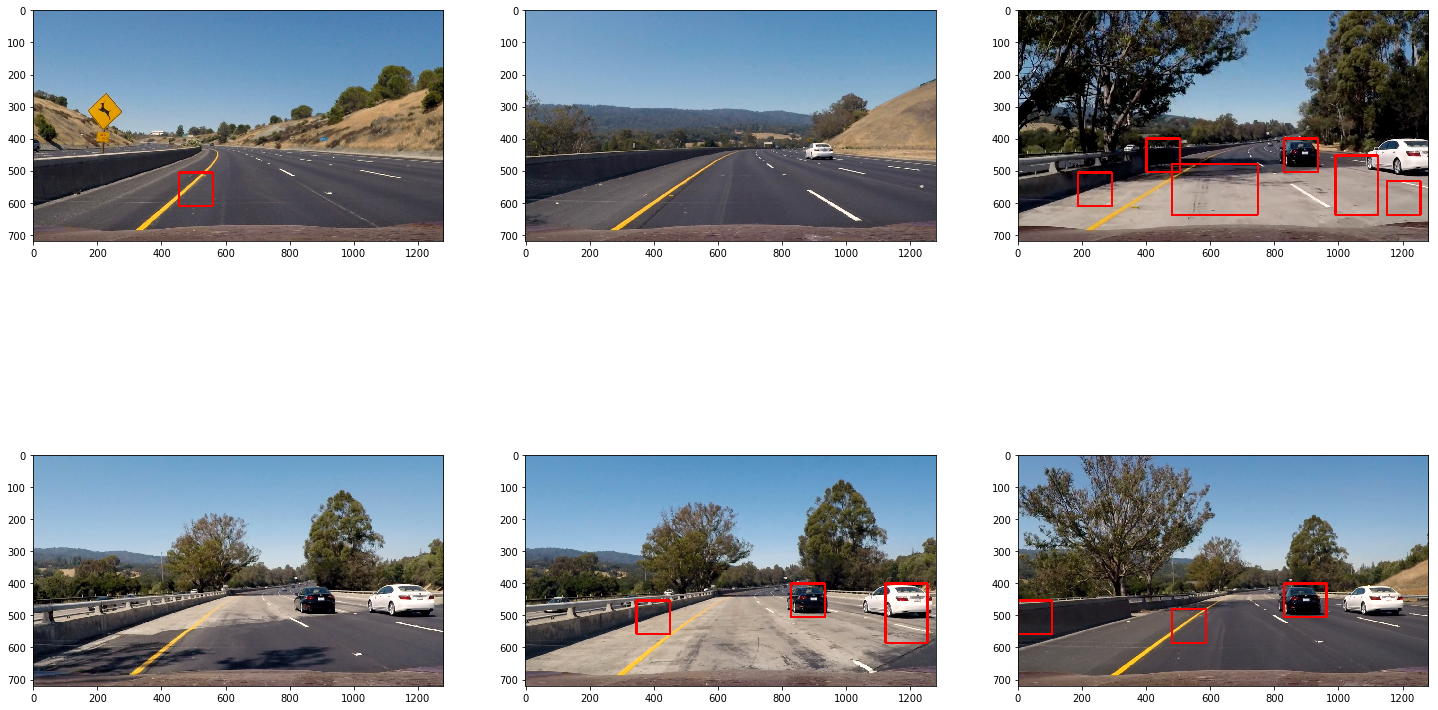

In [201]:
test_images = [] 
for filename in glob.glob('./test_images/*.jpg'): 
    test_images.append(filename) 
    
fig = plt.figure()
for i in range(len(test_images)):
    pic = cv2.imread(test_images[i])
    result = pipeline(pic)
    fig.add_subplot(2, 3, i+1)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    
fig.savefig("output.jpg")

In [107]:
white_output = 'test_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format("test_output.mp4"))

[MoviePy] >>>> Building video test_output.mp4
[MoviePy] Writing video test_output.mp4




  0%|          | 0/39 [00:00<?, ?it/s]

  3%|▎         | 1/39 [00:00<00:11,  3.21it/s]

  5%|▌         | 2/39 [00:00<00:11,  3.22it/s]

  8%|▊         | 3/39 [00:00<00:11,  3.19it/s]

 10%|█         | 4/39 [00:01<00:11,  3.16it/s]

 13%|█▎        | 5/39 [00:01<00:10,  3.10it/s]

 15%|█▌        | 6/39 [00:01<00:10,  3.05it/s]

 18%|█▊        | 7/39 [00:02<00:10,  3.02it/s]

 21%|██        | 8/39 [00:02<00:10,  3.01it/s]

 23%|██▎       | 9/39 [00:03<00:10,  2.98it/s]

KeyboardInterrupt: 

In [204]:
white_output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format("project_output.mp4"))

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4











  0%|          | 0/1261 [00:00<?, ?it/s]








  0%|          | 1/1261 [00:00<10:44,  1.96it/s]








  0%|          | 2/1261 [00:01<10:55,  1.92it/s]








  0%|          | 3/1261 [00:01<10:54,  1.92it/s]








  0%|          | 4/1261 [00:02<10:50,  1.93it/s]








  0%|          | 5/1261 [00:02<10:47,  1.94it/s]








  0%|          | 6/1261 [00:03<10:46,  1.94it/s]








  1%|          | 7/1261 [00:03<10:45,  1.94it/s]








  1%|          | 8/1261 [00:04<10:48,  1.93it/s]








  1%|          | 9/1261 [00:04<10:48,  1.93it/s]








  1%|          | 10/1261 [00:05<10:46,  1.93it/s]








  1%|          | 11/1261 [00:05<10:44,  1.94it/s]








  1%|          | 12/1261 [00:06<10:43,  1.94it/s]








  1%|          | 13/1261 [00:06<10:42,  1.94it/s]








  1%|          | 14/1261 [00:07<10:40,  1.95it/s]








  1%|          | 15/1261 [00:07<10:39,  1.95it/s]








  1%|▏         | 16/1261 [00:08<10:38,  1.95it/s]








  1%|▏         | 17/126

  8%|▊         | 96/1261 [00:51<10:28,  1.85it/s]








  8%|▊         | 97/1261 [00:52<10:29,  1.85it/s]








  8%|▊         | 98/1261 [00:53<10:29,  1.85it/s]








  8%|▊         | 99/1261 [00:53<10:29,  1.85it/s]








  8%|▊         | 100/1261 [00:54<10:30,  1.84it/s]








  8%|▊         | 101/1261 [00:54<10:31,  1.84it/s]








  8%|▊         | 102/1261 [00:55<10:31,  1.83it/s]








  8%|▊         | 103/1261 [00:56<10:31,  1.83it/s]








  8%|▊         | 104/1261 [00:56<10:31,  1.83it/s]








  8%|▊         | 105/1261 [00:57<10:30,  1.83it/s]








  8%|▊         | 106/1261 [00:57<10:30,  1.83it/s]








  8%|▊         | 107/1261 [00:58<10:30,  1.83it/s]








  9%|▊         | 108/1261 [00:59<10:30,  1.83it/s]








  9%|▊         | 109/1261 [00:59<10:30,  1.83it/s]








  9%|▊         | 110/1261 [01:00<10:31,  1.82it/s]








  9%|▉         | 111/1261 [01:01<10:32,  1.82it/s]








  9%|▉         | 112/1261 [01:01<10:32,  1.82it/s]








 

 15%|█▌        | 191/1261 [01:43<09:39,  1.85it/s]








 15%|█▌        | 192/1261 [01:43<09:38,  1.85it/s]








 15%|█▌        | 193/1261 [01:44<09:37,  1.85it/s]








 15%|█▌        | 194/1261 [01:44<09:37,  1.85it/s]








 15%|█▌        | 195/1261 [01:45<09:36,  1.85it/s]








 16%|█▌        | 196/1261 [01:46<09:36,  1.85it/s]








 16%|█▌        | 197/1261 [01:46<09:35,  1.85it/s]








 16%|█▌        | 198/1261 [01:47<09:34,  1.85it/s]








 16%|█▌        | 199/1261 [01:47<09:34,  1.85it/s]








 16%|█▌        | 200/1261 [01:48<09:33,  1.85it/s]








 16%|█▌        | 201/1261 [01:48<09:33,  1.85it/s]








 16%|█▌        | 202/1261 [01:49<09:32,  1.85it/s]








 16%|█▌        | 203/1261 [01:49<09:31,  1.85it/s]








 16%|█▌        | 204/1261 [01:50<09:31,  1.85it/s]








 16%|█▋        | 205/1261 [01:50<09:30,  1.85it/s]








 16%|█▋        | 206/1261 [01:51<09:29,  1.85it/s]








 16%|█▋        | 207/1261 [01:51<09:29,  1.85it/s]







 23%|██▎       | 286/1261 [02:33<08:44,  1.86it/s]








 23%|██▎       | 287/1261 [02:34<08:43,  1.86it/s]








 23%|██▎       | 288/1261 [02:34<08:42,  1.86it/s]








 23%|██▎       | 289/1261 [02:35<08:42,  1.86it/s]








 23%|██▎       | 290/1261 [02:35<08:41,  1.86it/s]








 23%|██▎       | 291/1261 [02:36<08:41,  1.86it/s]








 23%|██▎       | 292/1261 [02:36<08:40,  1.86it/s]








 23%|██▎       | 293/1261 [02:37<08:40,  1.86it/s]








 23%|██▎       | 294/1261 [02:37<08:39,  1.86it/s]








 23%|██▎       | 295/1261 [02:38<08:38,  1.86it/s]








 23%|██▎       | 296/1261 [02:38<08:38,  1.86it/s]








 24%|██▎       | 297/1261 [02:39<08:37,  1.86it/s]








 24%|██▎       | 298/1261 [02:39<08:36,  1.86it/s]








 24%|██▎       | 299/1261 [02:40<08:36,  1.86it/s]








 24%|██▍       | 300/1261 [02:40<08:35,  1.86it/s]








 24%|██▍       | 301/1261 [02:41<08:35,  1.86it/s]








 24%|██▍       | 302/1261 [02:42<08:34,  1.86it/s]







 30%|███       | 381/1261 [03:23<07:50,  1.87it/s]








 30%|███       | 382/1261 [03:24<07:49,  1.87it/s]








 30%|███       | 383/1261 [03:24<07:49,  1.87it/s]








 30%|███       | 384/1261 [03:25<07:48,  1.87it/s]








 31%|███       | 385/1261 [03:25<07:48,  1.87it/s]








 31%|███       | 386/1261 [03:26<07:47,  1.87it/s]








 31%|███       | 387/1261 [03:27<07:47,  1.87it/s]








 31%|███       | 388/1261 [03:27<07:47,  1.87it/s]








 31%|███       | 389/1261 [03:28<07:46,  1.87it/s]








 31%|███       | 390/1261 [03:29<07:46,  1.87it/s]








 31%|███       | 391/1261 [03:29<07:46,  1.86it/s]








 31%|███       | 392/1261 [03:30<07:46,  1.86it/s]








 31%|███       | 393/1261 [03:30<07:45,  1.86it/s]








 31%|███       | 394/1261 [03:31<07:45,  1.86it/s]








 31%|███▏      | 395/1261 [03:31<07:44,  1.86it/s]








 31%|███▏      | 396/1261 [03:32<07:44,  1.86it/s]








 31%|███▏      | 397/1261 [03:33<07:43,  1.86it/s]







 38%|███▊      | 476/1261 [04:19<07:08,  1.83it/s]








 38%|███▊      | 477/1261 [04:20<07:07,  1.83it/s]








 38%|███▊      | 478/1261 [04:20<07:07,  1.83it/s]








 38%|███▊      | 479/1261 [04:21<07:06,  1.83it/s]








 38%|███▊      | 480/1261 [04:21<07:06,  1.83it/s]








 38%|███▊      | 481/1261 [04:22<07:05,  1.83it/s]








 38%|███▊      | 482/1261 [04:23<07:05,  1.83it/s]








 38%|███▊      | 483/1261 [04:23<07:04,  1.83it/s]








 38%|███▊      | 484/1261 [04:24<07:04,  1.83it/s]








 38%|███▊      | 485/1261 [04:24<07:03,  1.83it/s]








 39%|███▊      | 486/1261 [04:25<07:03,  1.83it/s]








 39%|███▊      | 487/1261 [04:26<07:02,  1.83it/s]








 39%|███▊      | 488/1261 [04:26<07:02,  1.83it/s]








 39%|███▉      | 489/1261 [04:27<07:01,  1.83it/s]








 39%|███▉      | 490/1261 [04:27<07:01,  1.83it/s]








 39%|███▉      | 491/1261 [04:28<07:00,  1.83it/s]








 39%|███▉      | 492/1261 [04:28<07:00,  1.83it/s]







 45%|████▌     | 571/1261 [05:14<06:20,  1.81it/s]








 45%|████▌     | 572/1261 [05:15<06:19,  1.81it/s]








 45%|████▌     | 573/1261 [05:16<06:19,  1.81it/s]








 46%|████▌     | 574/1261 [05:16<06:18,  1.81it/s]








 46%|████▌     | 575/1261 [05:17<06:18,  1.81it/s]








 46%|████▌     | 576/1261 [05:17<06:17,  1.81it/s]








 46%|████▌     | 577/1261 [05:18<06:17,  1.81it/s]








 46%|████▌     | 578/1261 [05:19<06:16,  1.81it/s]








 46%|████▌     | 579/1261 [05:19<06:16,  1.81it/s]








 46%|████▌     | 580/1261 [05:20<06:15,  1.81it/s]








 46%|████▌     | 581/1261 [05:20<06:15,  1.81it/s]








 46%|████▌     | 582/1261 [05:21<06:15,  1.81it/s]








 46%|████▌     | 583/1261 [05:22<06:14,  1.81it/s]








 46%|████▋     | 584/1261 [05:22<06:13,  1.81it/s]








 46%|████▋     | 585/1261 [05:23<06:13,  1.81it/s]








 46%|████▋     | 586/1261 [05:23<06:12,  1.81it/s]








 47%|████▋     | 587/1261 [05:24<06:12,  1.81it/s]







 53%|█████▎    | 666/1261 [06:10<05:31,  1.80it/s]








 53%|█████▎    | 667/1261 [06:11<05:30,  1.79it/s]








 53%|█████▎    | 668/1261 [06:12<05:30,  1.79it/s]








 53%|█████▎    | 669/1261 [06:12<05:29,  1.79it/s]








 53%|█████▎    | 670/1261 [06:13<05:29,  1.79it/s]








 53%|█████▎    | 671/1261 [06:13<05:28,  1.79it/s]








 53%|█████▎    | 672/1261 [06:14<05:28,  1.79it/s]








 53%|█████▎    | 673/1261 [06:15<05:27,  1.79it/s]








 53%|█████▎    | 674/1261 [06:15<05:27,  1.79it/s]








 54%|█████▎    | 675/1261 [06:16<05:26,  1.79it/s]








 54%|█████▎    | 676/1261 [06:16<05:26,  1.79it/s]








 54%|█████▎    | 677/1261 [06:17<05:25,  1.79it/s]








 54%|█████▍    | 678/1261 [06:18<05:25,  1.79it/s]








 54%|█████▍    | 679/1261 [06:18<05:24,  1.79it/s]








 54%|█████▍    | 680/1261 [06:19<05:23,  1.79it/s]








 54%|█████▍    | 681/1261 [06:19<05:23,  1.79it/s]








 54%|█████▍    | 682/1261 [06:20<05:22,  1.79it/s]







 60%|██████    | 761/1261 [07:06<04:40,  1.79it/s]








 60%|██████    | 762/1261 [07:06<04:39,  1.78it/s]








 61%|██████    | 763/1261 [07:07<04:38,  1.78it/s]








 61%|██████    | 764/1261 [07:08<04:38,  1.78it/s]








 61%|██████    | 765/1261 [07:08<04:37,  1.78it/s]








 61%|██████    | 766/1261 [07:09<04:37,  1.78it/s]








 61%|██████    | 767/1261 [07:09<04:36,  1.78it/s]








 61%|██████    | 768/1261 [07:10<04:36,  1.78it/s]








 61%|██████    | 769/1261 [07:11<04:35,  1.78it/s]








 61%|██████    | 770/1261 [07:11<04:35,  1.78it/s]








 61%|██████    | 771/1261 [07:12<04:34,  1.78it/s]








 61%|██████    | 772/1261 [07:12<04:34,  1.78it/s]








 61%|██████▏   | 773/1261 [07:13<04:33,  1.78it/s]








 61%|██████▏   | 774/1261 [07:13<04:32,  1.78it/s]








 61%|██████▏   | 775/1261 [07:14<04:32,  1.78it/s]








 62%|██████▏   | 776/1261 [07:14<04:31,  1.78it/s]








 62%|██████▏   | 777/1261 [07:15<04:31,  1.78it/s]







 68%|██████▊   | 856/1261 [08:03<03:48,  1.77it/s]








 68%|██████▊   | 857/1261 [08:04<03:48,  1.77it/s]








 68%|██████▊   | 858/1261 [08:04<03:47,  1.77it/s]








 68%|██████▊   | 859/1261 [08:05<03:47,  1.77it/s]








 68%|██████▊   | 860/1261 [08:05<03:46,  1.77it/s]








 68%|██████▊   | 861/1261 [08:06<03:45,  1.77it/s]








 68%|██████▊   | 862/1261 [08:06<03:45,  1.77it/s]








 68%|██████▊   | 863/1261 [08:07<03:44,  1.77it/s]








 69%|██████▊   | 864/1261 [08:08<03:44,  1.77it/s]








 69%|██████▊   | 865/1261 [08:08<03:43,  1.77it/s]








 69%|██████▊   | 866/1261 [08:09<03:43,  1.77it/s]








 69%|██████▉   | 867/1261 [08:09<03:42,  1.77it/s]








 69%|██████▉   | 868/1261 [08:10<03:42,  1.77it/s]








 69%|██████▉   | 869/1261 [08:11<03:41,  1.77it/s]








 69%|██████▉   | 870/1261 [08:11<03:40,  1.77it/s]








 69%|██████▉   | 871/1261 [08:12<03:40,  1.77it/s]








 69%|██████▉   | 872/1261 [08:12<03:39,  1.77it/s]







 75%|███████▌  | 951/1261 [08:59<02:55,  1.76it/s]








 75%|███████▌  | 952/1261 [09:00<02:55,  1.76it/s]








 76%|███████▌  | 953/1261 [09:00<02:54,  1.76it/s]








 76%|███████▌  | 954/1261 [09:01<02:54,  1.76it/s]








 76%|███████▌  | 955/1261 [09:01<02:53,  1.76it/s]








 76%|███████▌  | 956/1261 [09:02<02:53,  1.76it/s]








 76%|███████▌  | 957/1261 [09:03<02:52,  1.76it/s]








 76%|███████▌  | 958/1261 [09:03<02:51,  1.76it/s]








 76%|███████▌  | 959/1261 [09:04<02:51,  1.76it/s]








 76%|███████▌  | 960/1261 [09:04<02:50,  1.76it/s]








 76%|███████▌  | 961/1261 [09:05<02:50,  1.76it/s]








 76%|███████▋  | 962/1261 [09:05<02:49,  1.76it/s]








 76%|███████▋  | 963/1261 [09:06<02:49,  1.76it/s]








 76%|███████▋  | 964/1261 [09:07<02:48,  1.76it/s]








 77%|███████▋  | 965/1261 [09:07<02:48,  1.76it/s]








 77%|███████▋  | 966/1261 [09:08<02:47,  1.76it/s]








 77%|███████▋  | 967/1261 [09:09<02:46,  1.76it/s]







 83%|████████▎ | 1045/1261 [09:55<02:03,  1.75it/s]








 83%|████████▎ | 1046/1261 [09:56<02:02,  1.75it/s]








 83%|████████▎ | 1047/1261 [09:56<02:01,  1.75it/s]








 83%|████████▎ | 1048/1261 [09:57<02:01,  1.75it/s]








 83%|████████▎ | 1049/1261 [09:57<02:00,  1.75it/s]








 83%|████████▎ | 1050/1261 [09:58<02:00,  1.75it/s]








 83%|████████▎ | 1051/1261 [09:59<01:59,  1.75it/s]








 83%|████████▎ | 1052/1261 [09:59<01:59,  1.75it/s]








 84%|████████▎ | 1053/1261 [10:00<01:58,  1.75it/s]








 84%|████████▎ | 1054/1261 [10:00<01:58,  1.75it/s]








 84%|████████▎ | 1055/1261 [10:01<01:57,  1.75it/s]








 84%|████████▎ | 1056/1261 [10:02<01:56,  1.75it/s]








 84%|████████▍ | 1057/1261 [10:02<01:56,  1.75it/s]








 84%|████████▍ | 1058/1261 [10:03<01:55,  1.75it/s]








 84%|████████▍ | 1059/1261 [10:03<01:55,  1.75it/s]








 84%|████████▍ | 1060/1261 [10:04<01:54,  1.75it/s]








 84%|████████▍ | 1061/1261 [10:05<01:54,

 90%|█████████ | 1139/1261 [10:52<01:09,  1.74it/s]








 90%|█████████ | 1140/1261 [10:53<01:09,  1.74it/s]








 90%|█████████ | 1141/1261 [10:54<01:08,  1.74it/s]








 91%|█████████ | 1142/1261 [10:54<01:08,  1.74it/s]








 91%|█████████ | 1143/1261 [10:55<01:07,  1.74it/s]








 91%|█████████ | 1144/1261 [10:56<01:07,  1.74it/s]








 91%|█████████ | 1145/1261 [10:56<01:06,  1.74it/s]








 91%|█████████ | 1146/1261 [10:57<01:05,  1.74it/s]








 91%|█████████ | 1147/1261 [10:57<01:05,  1.74it/s]








 91%|█████████ | 1148/1261 [10:58<01:04,  1.74it/s]








 91%|█████████ | 1149/1261 [10:59<01:04,  1.74it/s]








 91%|█████████ | 1150/1261 [10:59<01:03,  1.74it/s]








 91%|█████████▏| 1151/1261 [11:00<01:03,  1.74it/s]








 91%|█████████▏| 1152/1261 [11:00<01:02,  1.74it/s]








 91%|█████████▏| 1153/1261 [11:01<01:01,  1.74it/s]








 92%|█████████▏| 1154/1261 [11:02<01:01,  1.74it/s]








 92%|█████████▏| 1155/1261 [11:02<01:00,

 98%|█████████▊| 1233/1261 [11:49<00:16,  1.74it/s]








 98%|█████████▊| 1234/1261 [11:50<00:15,  1.74it/s]








 98%|█████████▊| 1235/1261 [11:50<00:14,  1.74it/s]








 98%|█████████▊| 1236/1261 [11:51<00:14,  1.74it/s]








 98%|█████████▊| 1237/1261 [11:51<00:13,  1.74it/s]








 98%|█████████▊| 1238/1261 [11:52<00:13,  1.74it/s]








 98%|█████████▊| 1239/1261 [11:53<00:12,  1.74it/s]








 98%|█████████▊| 1240/1261 [11:53<00:12,  1.74it/s]








 98%|█████████▊| 1241/1261 [11:54<00:11,  1.74it/s]








 98%|█████████▊| 1242/1261 [11:54<00:10,  1.74it/s]








 99%|█████████▊| 1243/1261 [11:55<00:10,  1.74it/s]








 99%|█████████▊| 1244/1261 [11:55<00:09,  1.74it/s]








 99%|█████████▊| 1245/1261 [11:56<00:09,  1.74it/s]








 99%|█████████▉| 1246/1261 [11:56<00:08,  1.74it/s]








 99%|█████████▉| 1247/1261 [11:57<00:08,  1.74it/s]








 99%|█████████▉| 1248/1261 [11:57<00:07,  1.74it/s]








 99%|█████████▉| 1249/1261 [11:58<00:06,

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 13min 40s, sys: 12.2 s, total: 13min 53s
Wall time: 12min 5s


In [119]:
white_output = 'test2.mp4'
clip2 = VideoFileClip("project_video.mp4").subclip(20.0,30.0)
white_clip = clip2.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format("test2.mp4"))

[MoviePy] >>>> Building video test2.mp4
[MoviePy] Writing video test2.mp4







  0%|          | 0/251 [00:00<?, ?it/s]




  0%|          | 1/251 [00:00<02:34,  1.62it/s]




  1%|          | 2/251 [00:01<02:37,  1.58it/s]




  1%|          | 3/251 [00:01<02:37,  1.58it/s]




  2%|▏         | 4/251 [00:02<02:37,  1.57it/s]




  2%|▏         | 5/251 [00:03<02:41,  1.52it/s]




  2%|▏         | 6/251 [00:03<02:41,  1.52it/s]




  3%|▎         | 7/251 [00:04<02:41,  1.51it/s]




  3%|▎         | 8/251 [00:05<02:41,  1.50it/s]




  4%|▎         | 9/251 [00:05<02:40,  1.50it/s]




  4%|▍         | 10/251 [00:06<02:40,  1.51it/s]




  4%|▍         | 11/251 [00:07<02:38,  1.51it/s]




  5%|▍         | 12/251 [00:07<02:37,  1.52it/s]




  5%|▌         | 13/251 [00:08<02:36,  1.52it/s]




  6%|▌         | 14/251 [00:09<02:35,  1.52it/s]




  6%|▌         | 15/251 [00:09<02:34,  1.52it/s]




  6%|▋         | 16/251 [00:10<02:33,  1.53it/s]




  7%|▋         | 17/251 [00:11<02:33,  1.53it/s]




  7%|▋         | 18/251 [00:12<02:36,  1.49it/s]




  8%|▊

 48%|████▊     | 120/251 [01:23<01:30,  1.44it/s]




 48%|████▊     | 121/251 [01:23<01:30,  1.44it/s]




 49%|████▊     | 122/251 [01:24<01:29,  1.44it/s]




 49%|████▉     | 123/251 [01:25<01:28,  1.44it/s]




 49%|████▉     | 124/251 [01:26<01:28,  1.44it/s]




 50%|████▉     | 125/251 [01:26<01:27,  1.44it/s]




 50%|█████     | 126/251 [01:27<01:26,  1.44it/s]




 51%|█████     | 127/251 [01:28<01:26,  1.44it/s]




 51%|█████     | 128/251 [01:28<01:25,  1.44it/s]




 51%|█████▏    | 129/251 [01:29<01:24,  1.44it/s]




 52%|█████▏    | 130/251 [01:30<01:23,  1.44it/s]




 52%|█████▏    | 131/251 [01:30<01:23,  1.44it/s]




 53%|█████▎    | 132/251 [01:31<01:22,  1.44it/s]




 53%|█████▎    | 133/251 [01:32<01:21,  1.44it/s]




 53%|█████▎    | 134/251 [01:32<01:21,  1.44it/s]




 54%|█████▍    | 135/251 [01:33<01:20,  1.44it/s]




 54%|█████▍    | 136/251 [01:34<01:19,  1.44it/s]




 55%|█████▍    | 137/251 [01:34<01:19,  1.44it/s]




 55%|█████▍    | 138/251 [01

 95%|█████████▍| 238/251 [02:47<00:09,  1.42it/s]




 95%|█████████▌| 239/251 [02:47<00:08,  1.42it/s]




 96%|█████████▌| 240/251 [02:48<00:07,  1.42it/s]




 96%|█████████▌| 241/251 [02:49<00:07,  1.42it/s]




 96%|█████████▋| 242/251 [02:50<00:06,  1.42it/s]




 97%|█████████▋| 243/251 [02:50<00:05,  1.42it/s]




 97%|█████████▋| 244/251 [02:51<00:04,  1.42it/s]




 98%|█████████▊| 245/251 [02:52<00:04,  1.42it/s]




 98%|█████████▊| 246/251 [02:52<00:03,  1.42it/s]




 98%|█████████▊| 247/251 [02:53<00:02,  1.42it/s]




 99%|█████████▉| 248/251 [02:54<00:02,  1.42it/s]




 99%|█████████▉| 249/251 [02:55<00:01,  1.42it/s]




100%|█████████▉| 250/251 [02:55<00:00,  1.42it/s]






[MoviePy] Done.
[MoviePy] >>>> Video ready: test2.mp4 

CPU times: user 3min 11s, sys: 775 ms, total: 3min 11s
Wall time: 2min 57s
